In [1]:
import tables as tb
import pandas as pd
import numpy as np

import invisible_cities.io.dst_io as dio
from utils.blob_distances_utils import bin_creator
from utils.plotting_utils import plot_cloud_voxels_and_hits_discrete
import matplotlib.pyplot as plt

Directory of the file

In [2]:
basedir = '/Users/mperez/NEXT/data_labelling/examples/JA_files/'

#labelled_file = basedir + 'Tl208_NEW_v1_03_01_nexus_v5_03_04_cut50.beersheba_label_4mm.h5'
labelled_file = basedir + 'merged_beersheba_label_4mm_50scut.h5'

In [3]:
with tb.open_file(labelled_file) as h5in:
    print(h5in)

/Users/mperez/NEXT/data_labelling/examples/JA_files/merged_beersheba_label_4mm_50scut.h5 (File) ''
Last modif.: 'Mon Apr 25 18:18:33 2022'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BeershebaVoxels (Table(5796404,), shuffle, zlib(4)) ''
/DATASET/BinsInfo (Table(1,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(28767,), shuffle, zlib(4)) ''
/DATASET/IsauraInfo (Table(40719,), shuffle, zlib(4)) ''
/DATASET/MCHits (Table(7168681,), shuffle, zlib(4)) ''



Definition of used functions

In [4]:
def voxelize_and_extract_single_particles(hits, bins, colnames = ['x', 'y', 'z']):
    '''
    bins es [bins_x, bins_y, bins_z]
    It also picks each particle for each event and each coordinate 
    '''
    for colname, bi in zip(colnames, bins):
        voxels = pd.cut(hits[colname], bi, labels = np.arange(0, len(bi) - 1)).fillna(0).astype(int)
        hits = hits.assign(**{colname:voxels})
    hits = hits.drop_duplicates(['x', 'y', 'z', 'particle_id', 'dataset_id'])
    return hits

In [5]:
def join_particle_process(particle_information):
    particle_dict = {'e-':'e', 'gamma':'phot'}
    creator_dict  = {'eIoni':'ioni', 'eBrem':'brem', 'phot':'photoel', 'RadioactiveDecay':'decay'}
    particle_information = particle_information.assign(particle_creator = particle_information['particle_name'].replace(particle_dict) + '_' + particle_information['creator_proc'].replace(creator_dict))
    return particle_information

In [6]:
def get_label_other_particles_new(path):
    
    labelled_MC_voxels = dio.load_dst(labelled_file, 'DATASET', 'BeershebaVoxels')
    labelled_MC_hits   = dio.load_dst(labelled_file, 'DATASET', 'MCHits')
    binsInfo  = dio.load_dst(labelled_file, 'DATASET', 'BinsInfo')
    
    bins = bin_creator(binsInfo)
    
    other_MC_voxels = labelled_MC_voxels[labelled_MC_voxels.segclass == 1]
    other_MC_voxels = other_MC_voxels.rename(columns = {'xbin':'x', 'ybin':'y', 'zbin':'z'})
    
    other_MC_hits   = labelled_MC_hits[labelled_MC_hits.segclass == 1]
        
    other_particle_voxels = voxelize_and_extract_single_particles(other_MC_hits, bins)
    
    other_voxels = other_MC_voxels.merge(other_particle_voxels[['x', 'y', 'z', 'particle_id', 'particle_name', 'creator_proc']], 
                                                               on = ['x', 'y', 'z'])
    
    other_hits   = join_particle_process(other_MC_hits.drop_duplicates(['dataset_id', 'particle_id']))
    other_voxels = join_particle_process(other_voxels.drop_duplicates(['dataset_id', 'particle_id']))
    
    return other_hits, other_voxels

In [7]:
other_hits, other_voxels = get_label_other_particles_new(labelled_file)

In [8]:
hits_plot = sorted(other_hits['particle_creator'].values, key = lambda x: x.split('_')[1])
vox_plot  = sorted(other_voxels['particle_creator'].values, key = lambda x: x.split('_')[1])

In [9]:
nbins = len(set(hits_plot))

In [10]:
xrange = (0, nbins)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

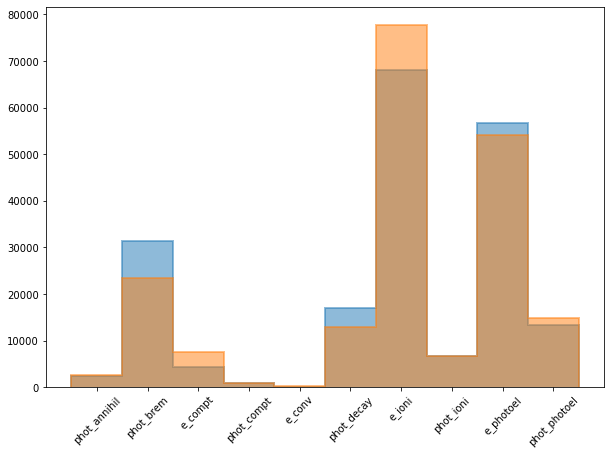

In [11]:
plt.figure(figsize = (10, 7))
plt.hist(hits_plot, bins = np.arange(nbins + 1) - 0.5, range = xrange, 
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2)
plt.hist(vox_plot, bins = np.arange(nbins + 1) - 0.5, range = xrange, 
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2)
plt.xticks(rotation = 45)


Con el plot sin la density podemos ver que los últimos son casi iguales (guesseo q es porque son cosas que están ''alejadas'' y siempre tienen representacion, mientras que lo demás se lo comen otras etiquetas quizás??)

Veamos qué es cada partícula de estas :)

In [27]:
other_hits[(other_hits.particle_creator == 'e_photoel')]

,x,y,z,hit_id,particle_id,energy,segclass,binclass,dist_hits,cumdist,particle_name,creator_proc,group_ener,small_b,dataset_id,particle_creator
238,120.188293,94.674187,432.884949,0,29,0.006103,1.0,0,0.0,0.0,e-,phot,0.041895,False,0,e_photoel
244,120.877403,87.505753,449.464264,0,31,0.005706,1.0,0,0.0,0.0,e-,phot,0.024364,False,0,e_photoel
498,-111.257339,-163.179596,449.303101,0,26,0.001022,1.0,1,0.0,0.0,e-,phot,0.138078,False,1,e_photoel
538,-112.315994,-161.869064,455.464996,0,28,0.007089,1.0,1,0.0,0.0,e-,phot,0.024364,False,1,e_photoel
712,-131.896622,90.752754,417.351898,0,27,0.009303,1.0,1,0.0,0.0,e-,phot,0.114275,False,2,e_photoel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7168363,48.894802,-116.771912,48.826241,0,23,0.003310,1.0,1,0.0,0.0,e-,phot,0.003310,False,28765,e_photoel
7168671,-25.635763,156.922150,156.648285,0,21,0.014763,1.0,0,0.0,0.0,e-,phot,0.014763,False,28766,e_photoel
7168672,-4.514605,146.998688,187.330261,0,22,0.009872,1.0,0,0.0,0.0,e-,phot,0.025425,False,28766,e_photoel
7168675,-15.432765,179.335815,259.563599,0,23,0.006450,1.0,0,0.0,0.0,e-,phot,0.019291,False,28766,e_photoel


# ANIHILATION
### PHOTON 

The anihilation photons are two 511 KeV photons that come from the anihilation of the positron with an electron in the chamber. They don't leave a track, they only depositate energy when creating another particle via some mechanisms (such as photons and electrons via photoelectric effect)

**In general i think that ALL photons that are represented only deposit a hit when interacting to create another particles; if a photon is created in any way and doesn't produce anything, it won't have any hit**

# BREMSSTRAHLUNG
### PHOTON 

Photon that arises from the deceleration of an electron.

# COMPTON

The compton scattering consists of a photon scattering with an electron, decreasing the photon energy, transmitted to the recoiling electron. I think that this decreased energy photon is considered as another particle, otherwise I don't know what it is.

### ELECTRON
The one coming from the radioactive decay usually is the background electron so it's not labelled as other, but a lot of times there are smaller compton electrons that arise from some different photons.

### PHOTON
When the electron appears, a photon also appears, but only deposits a hit when interacting (like before, triggering an electron through compton or photoelectric)

# CONVERSION

### ELECTRON
These are the cases where the positron didn't depositate any hit. It's well labelled in the binclass because I only pay attention to the MC particles, and if there is a positron, whereas for the segmentation I merge the MC hits and the MC particles so the positron ''desappears''. Then, the conversion electron is ignored. 

I think that this can be easily solved by selecting the signal events by the creator process ('conv') instead of by the presence of a positron. Once these events are well identified, all the e-e+ created by 'conv' are selected, but the error was in the previous event selection.

Change this:
*doublescape_event_ids = per_part_info[per_part_info.particle_name == 'e+'].event_id.unique()*

For this:
*doublescape_event_ids = per_part_info[per_part_info.creator_proc == 'conv'].event_id.unique()*

# RADIOACTIVE DECAY
### PHOTON

This photon only depositates energy, as always, when interacting to trigger an electron through compton or photoelectric effect. When triggering the electron and positron pair creation doesn't deposit energy!! 

Then, the background probably has a hit of this photon, and some of the signal events also but just because apart from the pair creation the photon creates another electron by compton or photoelectric.

# IONIZATION
An electron that ionizates the gas atoms.

### ELECTRON
When ionizated, the atom ejects an electron which usually leaves a very small track.

### PHOTON
I'm not sure how this photon is created, but I think that maybe the electron doesn't give enough energy to surpass the electron binding energy of the atom, so it deexcitates and reemits the adquired energy as a photon. Then, also, only depositates energy when interacting.

# PHOTOELECTRIC
Similar to compton I think but less energetic (?)
### ELECTRON

### PHOTON


<IPython.core.display.Javascript object>


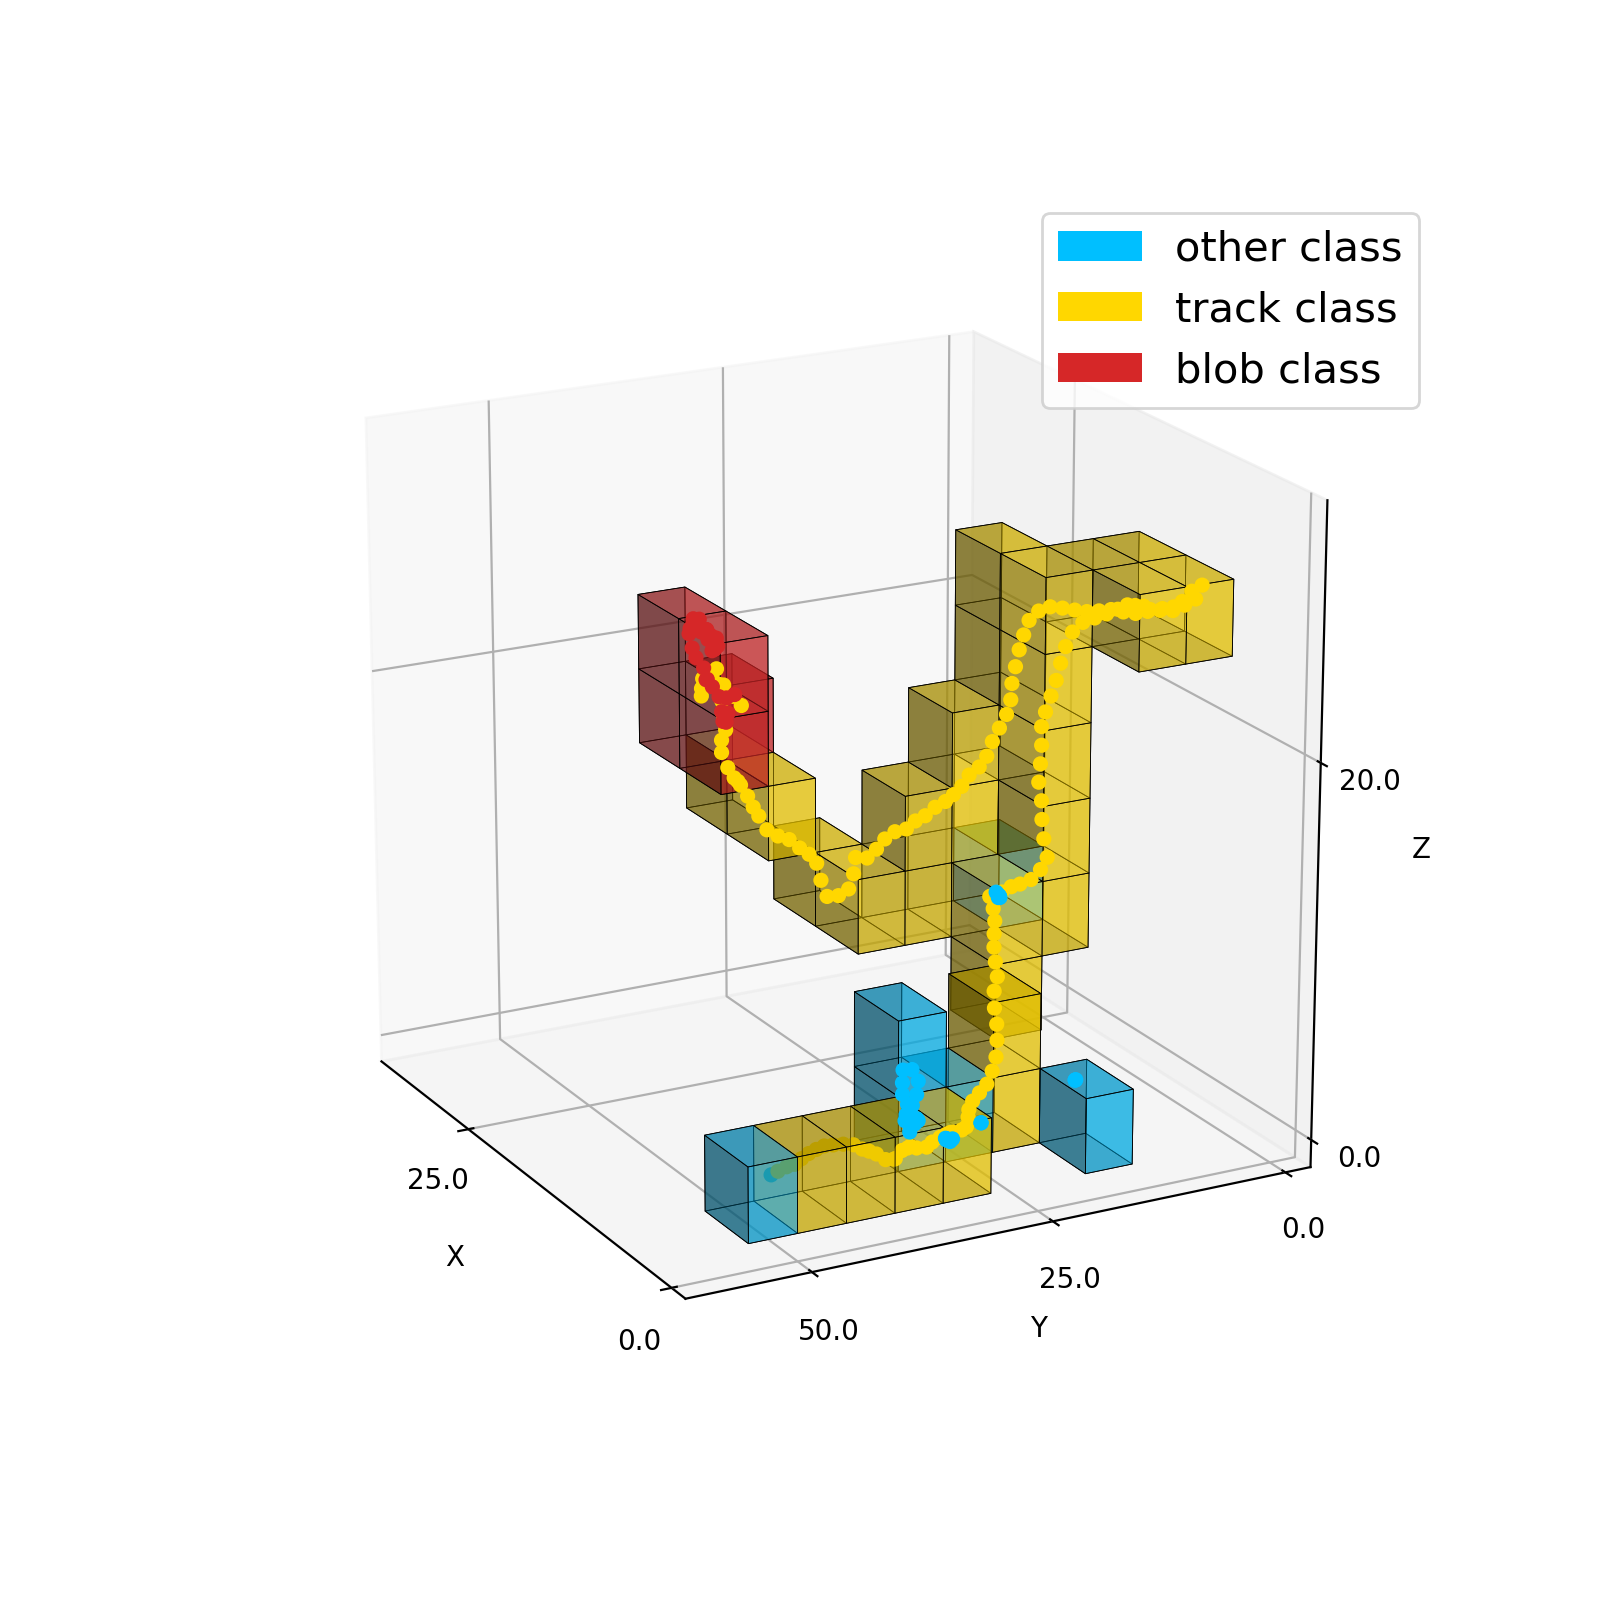

In [55]:
%matplotlib notebook
plot_cloud_voxels_and_hits_discrete(event_MC_voxels, event_MC_hits, voxel_size, start_bin, coords = ['x', 'y', 'z'], opacity = [0.5, 0.5, 1])

